In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import spaudiopy as spa
import utils as utils  # Note I was using utils_BKP before, so somethikgn might be broken
import plots

# Spatial Mixup - Directional Loudness Modification as Data Augmentation for Sound Event Localization and Detection #
Ricardo Falcon-Perez, Kazuki Shimada, Yuichiro Koyama, Shusuke Takahasi, Yuki Mitsufuji
2022

In this notebook we explore the theory behind the soundfield manipulations of spatial audio signals in the spherical harmonics domain. This is the basis used in the Spatial Mixup paper, where it is applied to data augmentation. For a quick reference on how to use Spatial Mixup please refer to the notebook: spatialmixup_demo.ipynb

In [23]:
params = {'t_design_degree': 4,
         'G_type': 'identity',
         'order_output': 1,
         'order_input': 1}

### Steps: ###
- Define a grid, by discrete sampling a unitary sphere. We use t-designs here.
- Compute a reconstruction matrix Y, with the spherical harmonics at the directions of the grid.
- Compute an analysis matrix W, that samples (spatially) the input soundfield. 
- Compute a directional gain matrix G, that selects the gain for each direction
- Finally, compute the full transformation $ T = Y \times G \times W $

In [4]:
# Define grid
grid = spa.grids.load_t_design(degree=params['t_design_degree'])

# Compute Y
tmp_directions = utils.vecs2dirs(grid)  # cartesian to spherical coordinates
Y = spa.sph.sh_matrix(params['order_output'], tmp_directions[:, 0], tmp_directions[:, 1], SH_type='real')
Y = torch.from_numpy(Y.transpose(1,0)).float()
print(f'Matrix Y of shape: {Y.shape}')

# Compute W
# In practice we can use W = Y.T ,as a hypercardiod beamformer
W = Y.transpose(1,0)
scale = 4 * np.pi / (params['order_input'] + 1)**2 # This is a hack
W = W * scale 
print(f'Matrix W of shape: {W.shape}')

# Compute G
G = torch.eye(Y.shape[-1])
print(f'Matrix G of shape: {G.shape}')

# Finally, we compute the full transformation matrix T
T = torch.matmul(Y, G)
T = torch.matmul(T, W)
print(f'Matrix T of shape: {T.shape}')

Matrix Y of shape: torch.Size([4, 12])
Matrix W of shape: torch.Size([12, 4])
Matrix G of shape: torch.Size([12, 12])
Matrix T of shape: torch.Size([4, 4])


We can visualize each matrix by looking at the polar patterns

(12, 4)


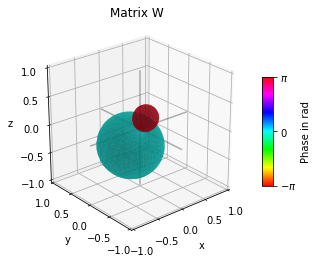

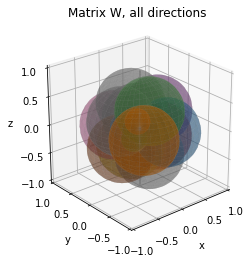

In [5]:
fig = plt.figure()
tmp = spa.sph.repeat_per_order(spa.sph.cardioid_modal_weights(params['order_input'])) * W.numpy()
print(tmp.shape)
spa.plots.sh_coeffs(W[5,:].numpy(), title="Matrix W".format(params['order_input']), fig=fig)

fig = plt.figure()
spa.plots.sh_coeffs_overlay([*W], fig=fig, title="Matrix W, all directions")

(12, 4)


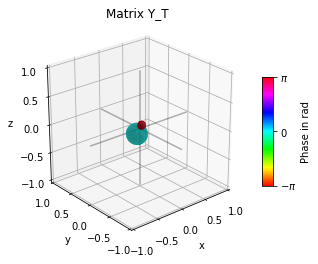

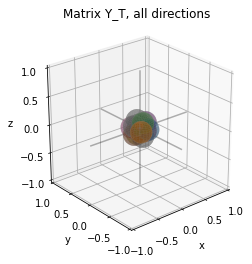

In [6]:
fig = plt.figure()
scale = 1
Y_t = Y.transpose(1,0)
tmp = spa.sph.repeat_per_order(spa.sph.cardioid_modal_weights(params['order_input'])) * Y_t.numpy()
print(tmp.shape)
spa.plots.sh_coeffs(Y_t[5,:].numpy() * scale, title="Matrix Y_T".format(params['order_input']), fig=fig)

fig = plt.figure()
spa.plots.sh_coeffs_overlay([*Y_t * scale], fig=fig, title="Matrix Y_T, all directions")

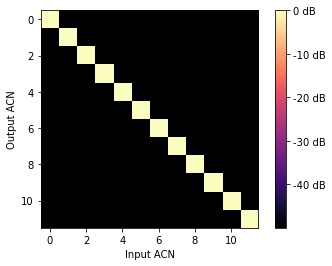

In [7]:
# Plotting G 
utils.plot_transform_matrix(G)

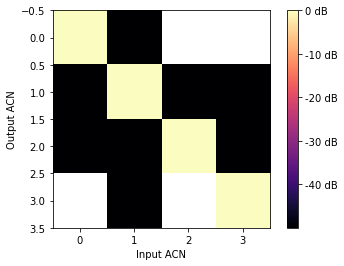

In [8]:
# Plotting T
scale =  4 * np.pi / G.shape[0]  # TODO: hacky scaling, this scaling makes my spherical plot look good, but it destroys the SPA test
scale = 1
utils.plot_transform_matrix(T * scale)

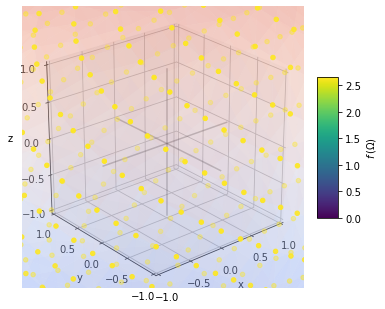

tensor([[[-0.1042, -0.1771,  0.1928,  ..., -0.1928,  0.1771,  0.1042],
         [-0.0936,  0.1656,  0.2463,  ...,  0.2463,  0.1656, -0.0936],
         [-2.6550, -2.6476, -2.6402,  ...,  2.6402,  2.6476,  2.6550]],

        [[ 0.0064, -0.0191,  0.0309,  ..., -0.0309,  0.0191, -0.0064],
         [ 0.0057,  0.0179,  0.0395,  ...,  0.0395,  0.0179,  0.0057],
         [ 0.1619, -0.2856, -0.4236,  ...,  0.4236,  0.2856, -0.1619]],

        [[ 0.1803,  0.3055, -0.3316,  ..., -0.3316,  0.3055,  0.1803],
         [ 0.1619, -0.2856, -0.4236,  ...,  0.4236,  0.2856, -0.1619],
         [ 4.5922,  4.5667,  4.5412,  ...,  4.5412,  4.5667,  4.5922]],

        [[ 0.0071,  0.0204,  0.0242,  ...,  0.0242,  0.0204,  0.0071],
         [ 0.0064, -0.0191,  0.0309,  ..., -0.0309,  0.0191, -0.0064],
         [ 0.1803,  0.3055, -0.3316,  ..., -0.3316,  0.3055,  0.1803]]],
       dtype=torch.float64)

In [11]:
utils.plot_sphere_points(T * scale, params['order_input'], plot_channel=0, show_plot=True)

In [12]:
# diffuse input SH signal
in_nm = np.random.randn((params['order_input']+1)**2, 1000).astype(np.float32)
print(in_nm.shape)
print(W.shape)
print(Y.shape)
# Sector signals (Analysis)
s_sec = W @ in_nm
print(s_sec.shape)
# Reconstruction to SH domain
out_nm = Y.conj() @ s_sec

# Test perfect reconstruction
print(spa.utils.test_diff(in_nm, out_nm))

(4, 1000)
torch.Size([12, 4])
torch.Size([4, 12])
torch.Size([12, 1000])
Diff:  6325.9263
6325.9263


#### Summary

This is the basic idea, but there are some issues:
- The scale of Y and W is wrong, so we lose some energy (that we correct with hacky scaling factor)
- The final transformation matrix T is not a full identity when G = identity, so there will be a few errors in the way.

## Using a Spatial FilterBank ##

Now we do the same, but using a properly designed Spatial Filterbank to get a perfect reconstruction of the input soundfield.
- Here the beamforming matrix can use different polar patterns. 
- The reconstruction matrix Y, now is constructed to compensate for any reconstruction errors.

In [75]:
params = {'t_design_degree': 7,
         'G_type': 'identity',
         'order_output': 2,
         'order_input': 2,
         'w_pattern': 'hypercardioid' }

# Define pattern for W
if params['w_pattern'].lower() == "cardioid":
    c_n = spa.sph.cardioid_modal_weights(params['order_input'])
elif params['w_pattern'].lower() == "hypercardioid":
    c_n = spa.sph.hypercardioid_modal_weights(params['order_input'])
elif params['w_pattern'].lower() == "maxre":
    c_n = spa.sph.maxre_modal_weights(params['order_input'], True)  # works with amplitude compensation and without!
else:
    assert()

In [76]:
# Define grid
grid = spa.grids.load_t_design(degree=params['t_design_degree'])
tmp_directions = utils.vecs2dirs(grid)  # cartesian to spherical coordinates

# Compute Y, W, and G, using a spatial filterbank with the selected directivity pattern
[W, Y] = spa.sph.design_spat_filterbank(params['order_output'], tmp_directions[:,0], tmp_directions[:,1], c_n, 'real', mode='perfect' )
Y = torch.from_numpy(Y).double()
W = torch.from_numpy(W).double()
G = torch.eye(W.shape[0]).double()

print(f'Matrix Y of shape: {Y.shape}')
print(f'Matrix G of shape: {G.shape}')

print(f'Matrix W of shape: {W.shape}')

# Finally, we compute the full transformation matrix T

T = torch.matmul(Y.transpose(1,0), G)
T = torch.matmul(T, W)

#scale =  4 * np.pi / G.shape[0]  # Hacky scaling
#T = T * scale
print(f'Matrix T of shape: {T.shape}')

Matrix Y of shape: torch.Size([24, 9])
Matrix G of shape: torch.Size([24, 24])
Matrix W of shape: torch.Size([24, 9])
Matrix T of shape: torch.Size([9, 9])


# This is not ready 

In [32]:
G = torch.tensor([[0.8343, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.5377, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5377, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5377, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5377, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8343, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5377, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5377, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5377,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.5377, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.5377, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.8343]]).double()

T = torch.matmul(Y.transpose(1,0), G)
T = torch.matmul(T, W)

In [41]:
# Usign hard cards
G = torch.tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.1125, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1125, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1125, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1125, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1125, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1125, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1125, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1125,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.1125, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1125, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.1125]]).double()

T = torch.matmul(Y.transpose(1,0), G)
T = torch.matmul(T, W)

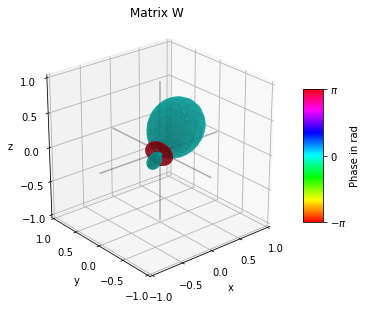

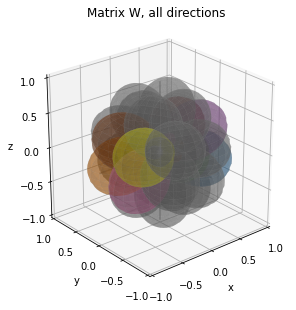

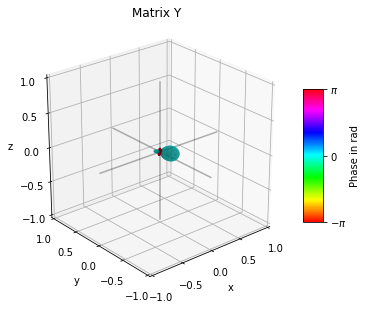

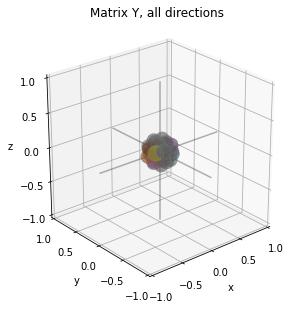

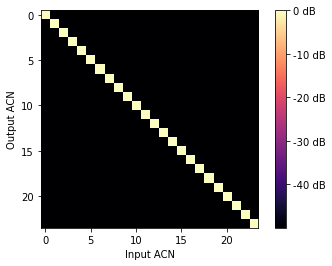

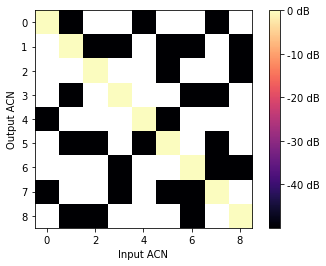

tensor([[ 1.0000e+00,  1.1602e-18, -8.3518e-17, -1.4572e-16,  5.5662e-17,
         -2.0685e-17, -2.2340e-16,  3.0272e-17, -8.4430e-17],
        [-4.3034e-17,  1.0000e+00,  6.1749e-18,  3.9266e-17, -1.2906e-16,
          1.2884e-16,  5.6089e-18, -2.5863e-17,  3.0293e-17],
        [-3.0832e-17, -1.4683e-17,  1.0000e+00, -4.6284e-18, -3.5285e-17,
          6.8198e-18, -6.1022e-16, -1.1765e-16,  4.8539e-17],
        [-1.3645e-16,  4.4254e-17, -7.5236e-19,  1.0000e+00, -1.2015e-17,
         -2.0472e-17,  5.5613e-17,  1.4533e-16, -1.2829e-16],
        [ 5.6729e-17, -1.3068e-16, -3.2184e-17, -5.0714e-18,  1.0000e+00,
          5.5717e-17, -3.8421e-17, -1.6346e-16, -3.3513e-18],
        [-1.3574e-17,  1.7889e-16,  1.0566e-17, -1.8935e-17,  6.8158e-17,
          1.0000e+00, -4.3832e-18,  3.5236e-17, -1.1400e-16],
        [-2.7498e-16, -1.6589e-17, -6.1217e-16,  4.4985e-17, -4.1667e-17,
         -1.2929e-17,  1.0000e+00,  2.5158e-17,  4.7176e-17],
        [ 2.5381e-17, -2.8906e-17, -1.7371e-16, 

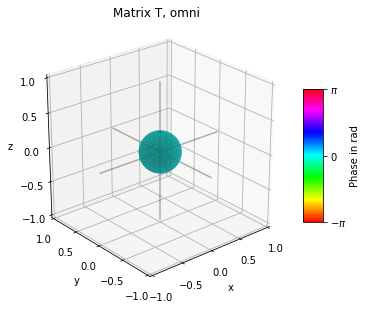

In [77]:
spa.plots.sh_coeffs(W[0,:].numpy(), title="Matrix W")
spa.plots.sh_coeffs_overlay([*W], title="Matrix W, all directions")
spa.plots.sh_coeffs(Y[1,:].numpy(), title="Matrix Y")
spa.plots.sh_coeffs_overlay([*Y], title="Matrix Y, all directions")
utils.plot_transform_matrix(G)

utils.plot_transform_matrix(T)

# To plot the full T, we look a the omni channel
spa.plots.sh_coeffs(T[0,:].numpy(), title='Matrix T, omni')
# UPDATE: This is wrong, not really a good way to visualize it

print(T)

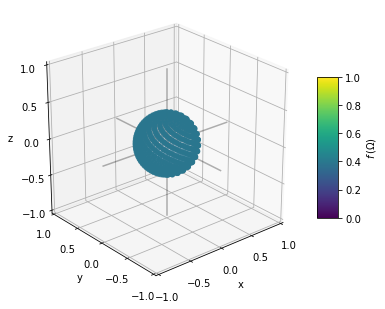

tensor([[[-1.5442e-02, -2.6241e-02,  2.8561e-02,  ..., -2.8561e-02,
           2.6241e-02,  1.5442e-02],
         [-1.3864e-02,  2.4527e-02,  3.6490e-02,  ...,  3.6490e-02,
           2.4527e-02, -1.3864e-02],
         [-3.9333e-01, -3.9224e-01, -3.9114e-01,  ...,  3.9114e-01,
           3.9224e-01,  3.9333e-01]],

        [[ 9.4139e-04, -2.8302e-03,  4.5830e-03,  ..., -4.5830e-03,
           2.8302e-03, -9.4139e-04],
         [ 8.4519e-04,  2.6454e-03,  5.8551e-03,  ...,  5.8551e-03,
           2.6454e-03,  8.4519e-04],
         [ 2.3979e-02, -4.2305e-02, -6.2763e-02,  ...,  6.2763e-02,
           4.2305e-02, -2.3979e-02]],

        [[ 2.6709e-02,  4.5261e-02, -4.9126e-02,  ..., -4.9126e-02,
           4.5261e-02,  2.6709e-02],
         [ 2.3979e-02, -4.2305e-02, -6.2763e-02,  ...,  6.2763e-02,
           4.2305e-02, -2.3979e-02],
         [ 6.8032e-01,  6.7654e-01,  6.7278e-01,  ...,  6.7278e-01,
           6.7654e-01,  6.8032e-01]],

        ...,

        [[-3.4385e-02, -5.7944e-02,

In [78]:
# So that looks ok, but I am not sure about the full T

utils.plot_sphere_points(T.float(), params['order_input'], plot_channel=0, show_plot=True, do_scaling=True)

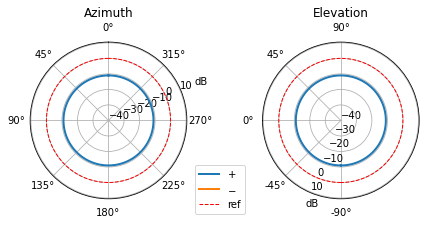

In [79]:
_ = utils.plot_matrix2polar(T.float(), params['order_input'], plot_channel=0, title='', show_plot=True, linewidth=2)

# It seems I am losing energy. Is it my plotting? OR am I missing scaling?

In [35]:
# diffuse input SH signal
in_nm = np.random.randn((params['order_input']+1)**2, 1000)
in_nm = in_nm / np.max(np.abs(in_nm))
print(in_nm.shape)
print(W.shape)
print(Y.shape)
# Sector signals (Analysis)
s_sec = W @ in_nm
print(s_sec.shape)
# Reconstruction to SH domain
out_nm = Y.conj().T @ s_sec.double()

# Test perfect reconstruction
print(spa.utils.test_diff(in_nm, out_nm))

# Test perfect reconstruction with power
print(spa.utils.test_diff(spa.utils.rms(in_nm), spa.utils.rms(out_nm.numpy())))

3.2943445359023666
(4, 1000)
-1.0
torch.Size([12, 4])
torch.Size([12, 4])
torch.Size([12, 1000])
Close enough.
1.6439532061227145e-13
Close enough.
1.1102230246251565e-16


#### Summary

This works better, but I still dont get:
- Why some t-design degree (e.g. 3, when order = 1 ) have higher errors. This is not super clear, but it is most likely because the test diff function is using the cumulative error and not just comparing each one. So the T matrix with t_desgin = 3 is close to identity, but not super quite close (1e-7) to zeros, so that introduces some errors.
- Using double seems very important, as using floats creates errors.
- I dont get how to visualize the output. --> fixed with the scaling 4pi / (N+1)**2 during ploting
- It seems I am losing energy. Is it my plotting? OR am I missing scaling? --> this was my plotting error

In [41]:
# From the spaudiopy documentation

N_sph = 1
t_degree = 2*N_sph
t_degree = 3  # Using 3 here will break tht test due to the cumulative error calculation

sec_dirs = spa.utils.cart2sph(*spa.grids.load_t_design(t_degree).T)
c_n = spa.sph.cardioid_modal_weights(N_sph)
[A, B] = spa.sph.design_spat_filterbank(N_sph, sec_dirs[0], sec_dirs[1],
                                        c_n, 'real', 'perfect')
A = A.astype(np.double)  # Very important to have doubles here, or it breaks
B = B.astype(np.double)

# diffuse input SH signal
in_nm = np.random.randn((N_sph+1)**2, 48000)
# Sector signals (Analysis)
s_sec = A @ in_nm
# Reconstruction to SH domain
out_nm = B.conj().T @ s_sec

print(sec_dirs[1].shape)
print(A.shape)
print(B.shape)
print(in_nm.shape)

# Test perfect reconstruction
print(spa.utils.test_diff(in_nm, out_nm)) # This is due to the cumulative sum of the error

a = spa.utils.rms(in_nm)
b = spa.utils.rms(out_nm)
print(spa.utils.test_diff(a, b))  # This looks good even for t-desgin = 3

(6,)
(6, 4)
(6, 4)
(4, 48000)
Diff:  0.017775962109841684
0.017775962109841684
Close enough.
2.2038018077097377e-09


In [42]:
def plot_sph_rms(F_nm):
    assert(F_nm.ndim == 2)
    grid_azi, grid_zen, grid_r = spa.utils.cart2sph(*spa.grids.load_n_design(40).T)
    # Looking with hyper-cardioids
    s_grid = F_nm @ ((4*np.pi)/((N_sph+1)**2) * spa.sph.sh_matrix(N_sph, grid_azi, grid_zen, 'real')).T
    s_rms = spa.utils.rms(s_grid, axis=0)  # why is this sqrt(4pi/nSH)?!
    print("RMS Mean: ", np.round(s_rms.mean(), 3))
    fig = plt.figure()
    spa.plots.spherical_function(s_rms, grid_azi, grid_zen, fig=fig)
    return s_rms.mean()

RMS Mean:  1.769
RMS Mean:  1.769


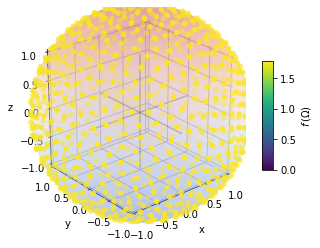

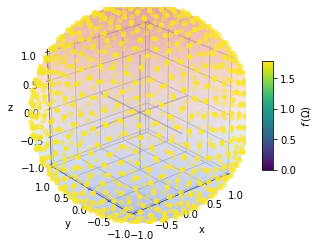

In [43]:
rms_in = plot_sph_rms(in_nm.T)
rms_in = plot_sph_rms(out_nm.T)


(4, 72000)
RMS Mean:  1.774
RMS Mean:  1.774


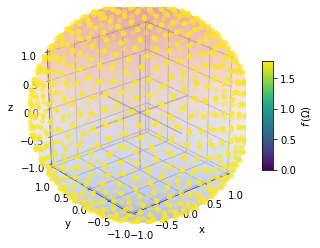

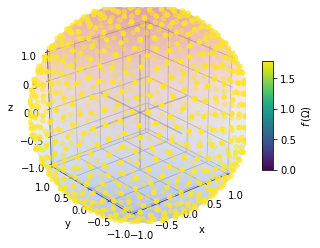

In [22]:
# Evaluation
from numpy.random import default_rng
rng = default_rng()

fs = 24000
t_sig = 3
in_nm_diff = 1 * rng.standard_normal((t_sig*fs, (N_sph+1)**2))
in_nm = in_nm_diff.T
print(in_nm.shape)
s_sec = A @ in_nm
# Reconstruction to SH domain
out_nm = B.conj().T @ s_sec

rms_in = plot_sph_rms(in_nm.T)
rms_in = plot_sph_rms(out_nm.T)


### Summary ###
That looks ok, but I dont get why the RMS is so huge.


(100, 1440)


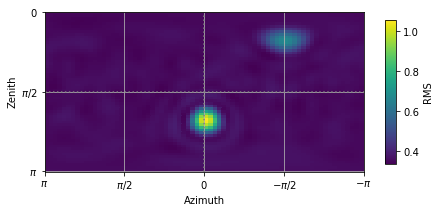

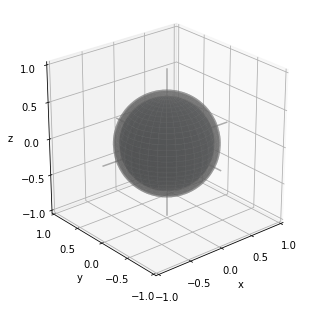

In [59]:
# INPUT
shtype = 'real'
Omega_in = np.c_[0, 0]
N_sph_in = 9
in_nm = spa.sph.sh_matrix(N_sph_in, Omega_in[:, 0], Omega_in[:, 1], shtype).conj()
in_nm = spa.sph.repeat_per_order(spa.sph.cardioid_modal_weights(N_sph_in)) * in_nm  # make cardioid
in_nm += spa.sph.sh_matrix(N_sph_in, Omega_in[:, 0]+np.pi/2, Omega_in[:, 1]+\
                           np.pi/2, shtype).conj() 


# Isotropic noise input
# Evaluation
from numpy.random import default_rng
rng = default_rng()

fs = 480
t_sig = 3
in_nm_diff = 1 * rng.standard_normal((t_sig*fs, (N_sph_in+1)**2))
in_nm_pw1 = 1 * rng.standard_normal((t_sig*fs, 1)) * spa.sph.sh_matrix(N_sph_in, tmp_directions[0,0], tmp_directions[0,1], shtype).conj()
in_nm_pw2 = 0.6 * rng.standard_normal((t_sig*fs, 1)) * spa.sph.sh_matrix(N_sph_in, tmp_directions[2,0], tmp_directions[2,1], shtype).conj()

in_nm = in_nm_diff + in_nm_pw1 + in_nm_pw2
#in_nm = np.ones([1, (N_sph+1)**2])
in_nm = in_nm.T
print(in_nm.shape)



assert in_nm.shape[0] < in_nm.shape[1], 'This should be channels first format'
spa.plots.sh_rms_map(in_nm)
#spa.plots.sh_coeffs_overlay([*in_nm[:,0]])  # This is kinda useless I think

In [1]:
%matplotlib widget
#%matplotlib notebook
# aka import ipympl

# Plotting the grid
grid = grid # In cartesian
tmp_directions = utils.vecs2dirs(grid)  # cartesian to spherical coordinates
colors = utils.get_cmap(grid.shape[0])
colors = np.arange(grid.shape[0]) / grid.shape[0]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(grid[:,0], grid[:,1], grid[:,2], c=colors, cmap='magma')

# Draw axis lines
x0 = np.array([1, 0, 0])
y0 = np.array([0, 1, 0])
z0 = np.array([0, 0, 1])
for i in range(3):
    ax.plot([-x0[i], x0[i]], [-y0[i], y0[i]], [-z0[i], z0[i]], '--k',
            alpha=0.3)
        
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_zticks([-1, -0.5, 0, 0.5, 1])
plt.title(f'T-design {grid.shape[0]} directions')

plt.show()

print(colors)

NameError: name 'grid' is not defined

# Demos:

### isotropic noise, signal (so with time)
- check for rms, maybe rms by framing, map and rms
- with identity
- with transform

### fake signal
this is liek chris example, so noise with some fake sources
- apply transform identityt, no change, map and rms
- apply spherical cap_soft, see change, map and rms
- apply spherical cap_hard, see change, map and rms

### Real dcase example
- apply identity, no change, map and rms and binarual render
- apply spherical cap soft, map, rms, and binarula render


### Compare patterns in G:
- random --> maybe not, this does not make sense
- random_diag --> weird potatos
- identity --> here the T mat is not really identity, due to the bad matrix Y and W in the vanilla code
- spherica_cap_soft
- spherical_cap_hard

In [67]:
# Lets do noise, and apply spatia mixup here

from numpy.random import default_rng
rng = default_rng()

fs = 480
t_sig = 7
N_sph_in=1
in_nm_diff = 1 * rng.standard_normal((t_sig*fs, (N_sph_in+1)**2))
in_nm_pw1 = 1 * rng.standard_normal((t_sig*fs, 1)) * spa.sph.sh_matrix(N_sph_in, tmp_directions[0,0], tmp_directions[0,1], shtype).conj()
in_nm_pw2 = 0.6 * rng.standard_normal((t_sig*fs, 1)) * spa.sph.sh_matrix(N_sph_in, tmp_directions[2,0], tmp_directions[2,1], shtype).conj()

in_nm = in_nm_diff + in_nm_pw1 + in_nm_pw2
#in_nm = np.ones([1, (N_sph+1)**2])
in_nm = in_nm.T
print(in_nm.shape)

import spatial_mixup_fixed as spm_f

transform = spm_f.DirectionalLoudness(t_design_degree=params['t_design_degree'], 
                                    G_type=params['G_type'], 
                                    order_output=params['order_output'], 
                                    order_input=params['order_input'])

out = transform.process(in_nm)
print(spa.utils.test_diff(in_nm, out)) 


(4, 3360)
>>>>>> DirLoud device : cpu
Diff:  37150.81736149936
37150.81736149936


# Putting it all together
Now we will do an example with plotting

Matrix Y of shape: torch.Size([24, 16])
Matrix G of shape: torch.Size([24, 24])
Matrix W of shape: torch.Size([24, 16])
Matrix T of shape: torch.Size([16, 16])
tensor([[ 1.0000e+00, -1.7544e-17, -5.2165e-17, -9.8483e-17,  1.1642e-17,
         -3.8437e-18, -6.3220e-17,  8.1342e-18, -2.3042e-17, -4.1475e-18,
         -1.4619e-18,  4.9677e-19, -1.7884e-18, -1.0435e-18,  1.8962e-18,
         -1.5397e-18],
        [-4.8245e-17,  1.0000e+00, -1.4605e-18,  2.9488e-17, -4.4204e-17,
          5.7126e-17, -8.6367e-18, -1.0509e-17, -8.4366e-18,  1.1727e-17,
          5.1051e-18, -1.0147e-17,  1.1249e-18,  3.7331e-19, -9.3971e-18,
         -6.9192e-19],
        [-5.7021e-17, -8.6846e-18,  1.0000e+00,  4.7827e-18, -8.7083e-18,
         -5.1915e-18, -2.0711e-16, -4.1453e-17,  1.4851e-17, -5.2013e-18,
         -3.1997e-19, -1.8366e-18, -2.5697e-18,  1.6793e-18, -3.3301e-18,
         -5.6303e-18],
        [-1.8074e-16,  3.1111e-17, -1.1790e-17,  1.0000e+00, -3.2655e-18,
         -6.2400e-18,  2.2771e-

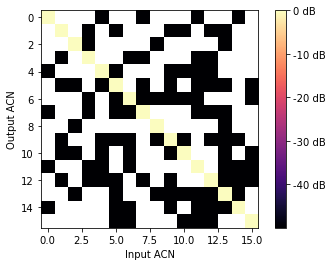

In [73]:
params = {'t_design_degree': 7,
         'G_type': 'identity',
         'order_output': 3,
         'order_input': 3,
         'w_pattern': 'cardioid' }

# Define pattern for W
if params['w_pattern'].lower() == "cardioid":
    c_n = spa.sph.cardioid_modal_weights(params['order_input'])
elif params['w_pattern'].lower() == "hypercardioid":
    c_n = spa.sph.hypercardioid_modal_weights(params['order_input'])
elif params['w_pattern'].lower() == "maxre":
    c_n = spa.sph.maxre_modal_weights(params['order_input'], True)  # works with amplitude compensation and without!
else:
    assert()

    
# Define grid
grid = spa.grids.load_t_design(degree=params['t_design_degree'])
tmp_directions = utils.vecs2dirs(grid)  # cartesian to spherical coordinates

# Compute Y, W, and G, using a spatial filterbank with the selected directivity pattern
[W, Y] = spa.sph.design_spat_filterbank(params['order_output'], tmp_directions[:,0], tmp_directions[:,1], c_n, 'real', mode='perfect' )
Y = torch.from_numpy(Y).double()
W = torch.from_numpy(W).double()
G = torch.eye(W.shape[0]).double()

if False:
    values = np.zeros_like(G.diag())
    values[0] = 1
    np.fill_diagonal(G.numpy(), values)

print(f'Matrix Y of shape: {Y.shape}')
print(f'Matrix G of shape: {G.shape}')
print(f'Matrix W of shape: {W.shape}')

# Finally, we compute the full transformation matrix T
T = torch.matmul(Y.transpose(1,0), G)
T = torch.matmul(T, W)

print(f'Matrix T of shape: {T.shape}')
print(T)
plots.plot_transform_matrix(T, xlabel='Input ACN', ylabel='Output ACN')

(16, 840)
RMS Mean:  0.886


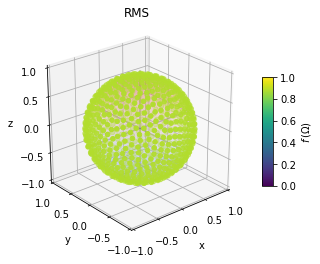

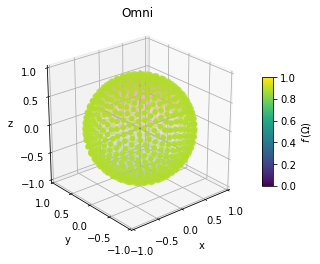

(16, 840)
(16, 840)
(840, 840)
Matrix T: torch.Size([16, 16])


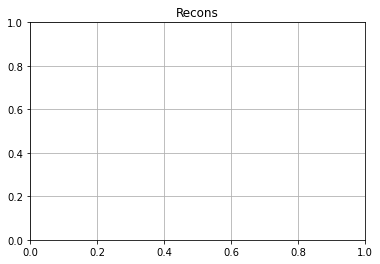

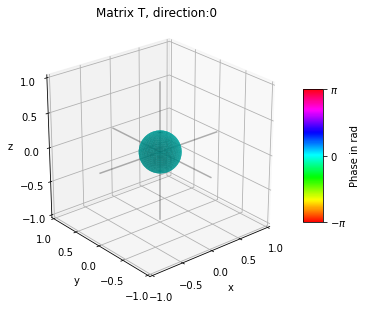

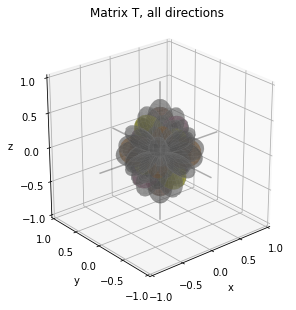

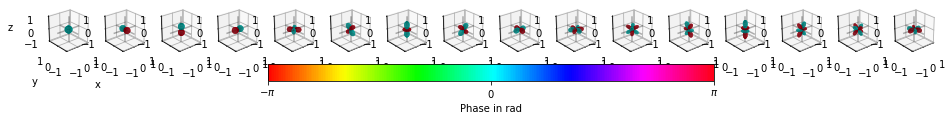

In [84]:
# plot response
grid_azi, grid_zen, grid_r = spa.utils.cart2sph(*spa.grids.load_n_design(40).T)

# Encode points
scale = (4*np.pi)/((params['order_input']+1)**2)
scale = np.pi
s_grid = scale * spa.sph.sh_matrix(params['order_input'], grid_azi, grid_zen, 'real').T

# Transform
s_grid = T @ s_grid 
s_grid = s_grid.numpy()

print(s_grid.shape)
s_rms = spa.utils.rms(s_grid, axis=0)
print("RMS Mean: ", np.round(s_rms.mean(), 3))
fig = plt.figure()
spa.plots.spherical_function(s_rms, grid_azi, grid_zen, fig=fig, title='RMS')
plt.show()
fig = plt.figure()
spa.plots.spherical_function(s_grid[0,:], grid_azi, grid_zen, fig=fig, title='Omni')
plt.show()

# this is wrong:
w_t = scale * spa.sph.sh_matrix(params['order_input'], grid_azi, grid_zen, 'real').T
recons = spa.sph.inverse_sht(s_grid, grid_azi, grid_zen, 'real')
spa.plots.spherical_function(recons[:,0], grid_azi, grid_zen, fig=fig, title='Recons')
print(w_t.shape)
print(s_grid.shape)
#recons = w_t.T @ s_grid
print(recons.shape)



print(f'Matrix T: {T.shape}')
spa.plots.sh_coeffs(T[0,:].numpy(), title=f'Matrix T, direction:{0}')
spa.plots.sh_coeffs_overlay([*T], title="Matrix T, all directions")
spa.plots.sh_coeffs_subplot(T[:,:])
plt.show()

In [69]:
# Test with Input signal (noise floor, with some noise sources)
# Some directions:
from numpy.random import default_rng
rng = default_rng()
grid = spa.grids.load_t_design(degree=params['t_design_degree'])
tmp_directions = utils.vecs2dirs(grid) 

fs = 48000
t_sig = 3  # in seconds
in_nm_diff = 1 * rng.standard_normal((t_sig*fs, (params['order_input']+1)**2))
in_nm_pw1 = 1 * rng.standard_normal((t_sig*fs, 1)) * spa.sph.sh_matrix(params['order_input'], tmp_directions[0,0], tmp_directions[0,1], 'real').conj()
in_nm_pw2 = 0.6 * rng.standard_normal((t_sig*fs, 1)) * spa.sph.sh_matrix(params['order_input'], tmp_directions[2,0], tmp_directions[2,1], 'real').conj()

in_nm = in_nm_diff + in_nm_pw1 + in_nm_pw2
in_nm = in_nm.T

out = T @ in_nm

print(in_nm.shape)
print(out.shape)
print(spa.utils.test_diff(in_nm, out)) 
print(spa.utils.test_diff(spa.utils.rms(in_nm), spa.utils.rms(out.numpy()))) 

(9, 144000)
torch.Size([9, 144000])
Close enough.
1.3406359048522745e-09
Close enough.
3.352873534367973e-14
